In [ ]:
# import all packages and set plots to be embedded inline
import numpy as np
import scipy.stats as st
from scipy.integrate import quad
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
import seaborn as sns
#import statsmodels.api as sm
import pandas as pd
import os
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize


%matplotlib inline
np.set_printoptions(precision=2,suppress=True)

Load the mass of each alcohol and its respective FOM in mixture

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
x, y= np.load("/content/drive/MyDrive/UofT_Courses/MIE1666_ML/3_ML_Project/mass_batch.npy"), np.load("/content/drive/MyDrive/UofT_Courses/MIE1666_ML/3_ML_Project/res_v.npy")

In [ ]:
plt.plot(y)

In [1]:
a= range(4)
print(a)

range(0, 4)


In [49]:
'''initial_X = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1],
                    [0.5, 0.5, 0], [0, 0.5, 0.5], [0.5, 0, 0.5]
                    ])'''
# Number of arrays to randomly sample
num_arrays_to_sample = 100  # You can adjust this as needed

# Randomly choose one or more arrays from the nested array
random_arrays_indices = np.random.choice(x.shape[0], size=num_arrays_to_sample, replace=False)
random_arrays = x[random_arrays_indices]
initial_X = random_arrays

initial_y = []
for i in initial_X:
    indice = np.where(np.all(x == i, axis=1))[0][0]
    initial_y.append(y[indice])

initial_y = np.array(initial_y)

X_train, y_train = initial_X, initial_y

Optimal Hyperparameters: [0.23 3.   0.8 ]


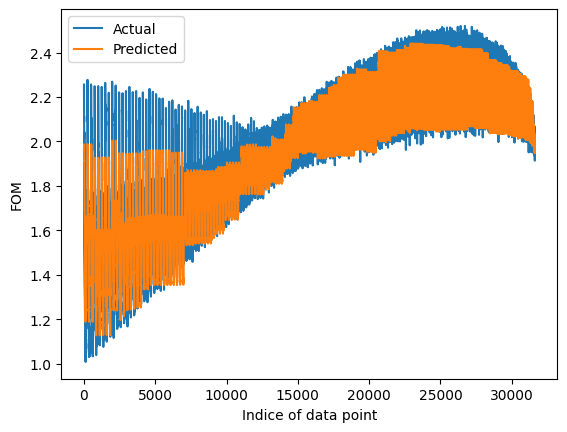

In [50]:
# Define the XGBoost model
model = xgb.XGBRegressor(objective="reg:squarederror")

# Define the objective function for XGBoost training
def xgb_objective(params):
    learning_rate, max_depth, subsample = params
    model.set_params(learning_rate=learning_rate, max_depth=int(round(max_depth)), subsample=subsample)

    model.fit(X_train, y_train)
    predictions = model.predict(X_train)

    mse = mean_squared_error(y_train, predictions)
    return mse

# Define the search space for hyperparameters
space = [(0.01, 0.3),  # learning_rate
         (3, 10),       # max_depth
         (0.5, 1.0)]     # subsample

# Minimize the XGBoost objective function
result = minimize(xgb_objective, x0=[0.1, 0.1, 0.8], bounds=space, method="L-BFGS-B")

# Get the optimal hyperparameters
optimal_params = result.x
print("Optimal Hyperparameters:", optimal_params)

# Set the XGBoost model with the optimal hyperparameters
optimal_learning_rate, optimal_max_depth, optimal_subsample = optimal_params
model.set_params(learning_rate=optimal_learning_rate, max_depth=int(round(optimal_max_depth)), subsample=optimal_subsample)

# Train the final model with optimal hyperparameters
model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = model.predict(x)

plt.plot(y)
plt.plot(y_val_pred)
plt.xlabel('Indice of data point')
plt.ylabel('FOM')
plt.legend(['Actual', 'Predicted'])

In [ ]:
# Train initial Gaussian Process (GP) model
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model = gp.GaussianProcessRegressor(kernel=kernel,
                                    optimizer='fmin_l_bfgs_b',
                                    n_restarts_optimizer=30,
                                    alpha=1e-3,
                                    normalize_y=True)

#model.fit(initial_X, initial_y)

In [ ]:
# Expected Improvement-based active learning function
def EI_learning(candidates, y_pred, pred_std):
    """Active learning function based on expected improvement

       This function selects a new sample from candidate pool to enrich the current training dataset.
       The sample gets selected if it has the maximum expected improvement value.

       Input:
       - candidates: pool of candidates to select sample from
       - y_pred: GP predictions on candidate samples
       - pred_std: Standard deviation of the GP predictions on candidate samples

       Output:
       - new_sample: the selected sample with the maximum expected improvement value
       - EI: EI values of the candidate samples
    """

    # 1-Find the current maxima
    current_objective = y_pred[np.argmax(y_pred)]

    # 2-Calculate the EI values of the candidate samples
    #pred_std = pred_std.reshape(pred_std.shape[0], 1)
    EI = (current_objective-y_pred)*st.norm.cdf((current_objective-y_pred)/pred_std) \
            +pred_std*st.norm.pdf((current_objective-y_pred)/pred_std)

    # 3-Select a new sample
    new_sample = candidates[np.argmax(EI)]

    return new_sample, EI

In [ ]:
#iterate 5 times and see results change

n_iterations = 5
y_pred_arr, EI_arr = [], []

for c in range(n_iterations):
    print('-----------------------------------------------')
    print("Iteration : {}".format(c))
    model.fit(initial_X, initial_y)
    y_pred, pred_std = model.predict(X_norm, return_std=True)
    y_pred_arr.append(y_pred)

    pred_std = pred_std.flatten()

    index = np.argmax(y_pred)
    current_location = X_norm[index]
    current_objective = y_pred[index]
    print("Current location : {}".format(current_location))
    print("Current objective value : {}".format(current_objective))
    print("Targeted objective value : {}".format(y[np.argmax(y)]))

    new_sample, EI_new = EI_learning(X_norm, y_pred, pred_std)
    EI_arr.append(EI_new)
    print("Next best data point : {}".format(new_sample))

    initial_X = np.vstack([initial_X, new_sample])
    initial_y = []

    for i in initial_X:
        indice = np.where(np.all(X_norm == i, axis = 1))[0][0]
        initial_y.append(y[indice])

    initial_y = np.array(initial_y)

-----------------------------------------------
Iteration : 0
Current location : [0.65 0.24 0.11]
Current objective value : 4.9584355328083545
Targeted objective value : 7.550369650888264
Next best data point : [0.62 0.   0.38]
-----------------------------------------------
Iteration : 1
Current location : [0.61 0.39 0.  ]
Current objective value : 5.312952831098944
Targeted objective value : 7.550369650888264
Next best data point : [0.42 0.   0.58]
-----------------------------------------------
Iteration : 2
Current location : [0.4 0.6 0. ]
Current objective value : 5.747665924521465
Targeted objective value : 7.550369650888264
Next best data point : [0.09 0.   0.91]
-----------------------------------------------
Iteration : 3
Current location : [0. 1. 0.]
Current objective value : 6.948426662129007
Targeted objective value : 7.550369650888264
Next best data point : [0. 0. 1.]
-----------------------------------------------
Iteration : 4
Current location : [0. 1. 0.]
Current object

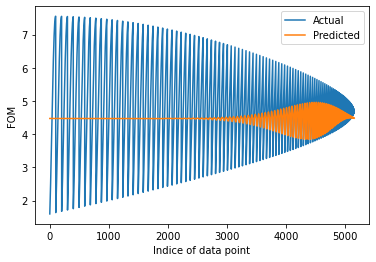

In [ ]:
plt.plot(y)
plt.plot(y_pred_arr[0])
plt.xlabel('Indice of data point')
plt.ylabel('FOM')
plt.legend(['Actual', 'Predicted'])

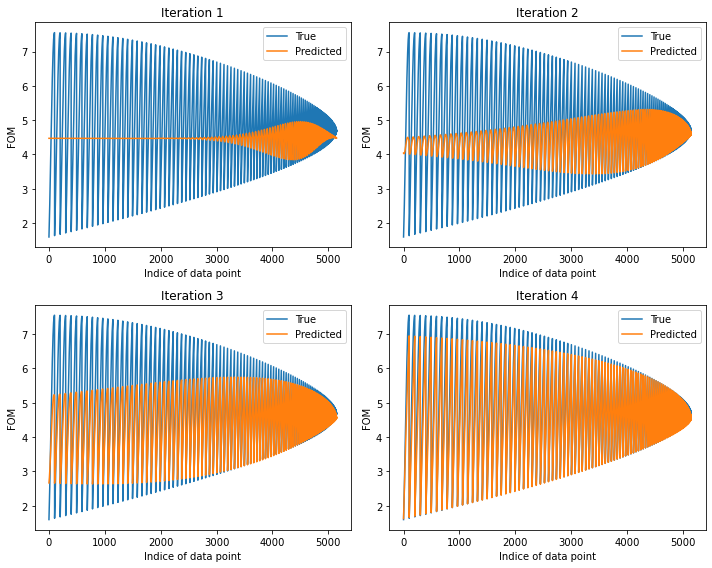

In [ ]:
plt.figure(figsize=(10, 8))

for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.plot(y)
    plt.plot(y_pred_arr[i-1])
    plt.xlabel('Indice of data point')
    plt.ylabel('FOM')
    plt.legend(['True', 'Predicted'], loc = 'upper right') #commented out because legend takes a lot of space
    plt.title('Iteration {}'.format(i))

plt.tight_layout()
plt.show()